<a href="https://colab.research.google.com/github/ansonmiu0214/SessionTS-Benchmarks/blob/master/Benchmarks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Performance Benchmarks

Use this notebook to process the log files
available in the repository from running the
performance benchmarks locally.

The log files are obtained by running the _PingPong_
binary session protocol $n$ times.

--

__May 30, 2020:__ logs available for $n \in \{ 10^2, 10^3, 10^4 \}$

## Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

%matplotlib inline

In [2]:
import os
import shutil

repo_path = '/content/SessionTS-Benchmarks'
if os.path.exists(repo_path):
    print('Note: deleting stale repo')
    shutil.rmtree(repo_path)

!git clone https://github.com/ansonmiu0214/SessionTS-Benchmarks
benchmark_path = repo_path
assert os.path.exists(benchmark_path), 'Benchmark path not found'

Cloning into 'SessionTS-Benchmarks'...
remote: Enumerating objects: 281, done.
remote: Counting objects: 100% (281/281), done.
remote: Compressing objects: 100% (255/255), done.
remote: Total 281 (delta 27), reused 269 (delta 23), pack-reused 0
Receiving objects: 100% (281/281), 5.04 MiB | 18.99 MiB/s, done.
Resolving deltas: 100% (27/27), done.


## Helper functions

In [3]:
def from_ms(ms):
    """Parse numerical millisecond value from string suffixed with 'ms'.'"""
    
    return float(ms[:-2])

def parse_log(content, prefix = 'benchmark'):
    """Parse log content generated from repo benchmarking tools.
    
    Returns (message_sent, elapsed_ms, total_elapsed_ms),
    where (message_sent, elapsed_ms) are used for plotting."""

    relevant_lines = [line.strip() for line in content
                      if line.startswith(prefix) and line.strip()]

    message_sent = [0]
    elapsed_ms = [0.0]
    total_elapsed_ms = None

    for line in relevant_lines:
        components = line.split(' ')
        if len(components) == 3:
            _, time, count = line.split(' ')
            message_sent.append(int(count))
            elapsed_ms.append(from_ms(time))
        else:
            _, total_elapsed_str = components
            total_elapsed_ms = from_ms(total_elapsed_str)

    if total_elapsed_ms is None:
        total_elapsed_ms = elapsed_ms[-1]

    return message_sent, elapsed_ms, total_elapsed_ms

In [4]:
def accumulate_logs(label, message_count):
    """Parse all log files for benchmarking {label} implementation of
    running PingPong {message_count} times.
    
    Returns a list of (xs, ys) for plotting and 
    the averaged total elapsed time over all log files."""
    
    log_dir = os.path.join(benchmark_path, label, 'server', 'logs')
    relevant_logs = [log for log in os.listdir(log_dir)
                     if int(log.split('_')[0]) == message_count]

    datasets = []
    average_elapsed = 0.0

    for log in relevant_logs:
        log_path = os.path.join(log_dir, log)
        with open(log_path, 'r') as log_file:
            message_count, elapsed, total_elapsed = parse_log(log_file)
            datasets.append((message_count, elapsed))
            average_elapsed += total_elapsed

    average_elapsed /= len(relevant_logs)

    return datasets, average_elapsed

## Data Loader

Update `num_messages` and `categories` depending
on what is available in the log folders.

In [5]:
num_messages = [100, 1_000, 10_000]
categories = ['bare', 'bare_safe', 'mpst']

In [6]:
from collections import defaultdict

class BenchmarkData:

    def __init__(self, num_messages, categories, *, fmt='.2f'):
        self.num_messages = num_messages
        self.categories = categories
        self.fmt = fmt

        self.message_dict = defaultdict(defaultdict)
        self.category_dict = defaultdict(defaultdict)

        # Aggregate data from all log files.
        for category in categories:
            for message_count in num_messages:
                log = accumulate_logs(category, message_count)
                self.message_dict[message_count][category] = log
                self.category_dict[category][message_count] = log

        # Build factory for generating fresh DataFrame
        # with columns and index set up.
        self.df_factory = lambda: pd.DataFrame(columns=categories,
                                               index=num_messages)
    
    def df_total_elapsed(self):
        """Returns dataframe showing total elapsed time for execution."""

        df = self.df_factory()
        for message_count, data in self.message_dict.items():
            df.loc[message_count] = [format(data[category][1], self.fmt)
                                     for category in self.categories]
        return df


    def df_average_elapsed(self):
        """Returns dataframe showing average elapsed time per message
        for execution."""

        df = self.df_factory()
        for message_count, data in self.message_dict.items():
            df.loc[message_count] = [format(data[category][1] / message_count, self.fmt)
                                     for category in self.categories]
        return df

    def plt_average_elapsed(self):
        """Returns pivot table showing average elapsed time per message
        for execution, suitable for plotting grouped bar-chart."""

        table = []
        for category, data in self.category_dict.items():
            for message_count, (_, elapsed) in data.items():
                table.append([message_count, category, elapsed / message_count])
        df = pd.DataFrame(table, 
                          columns=['number of messages',
                                   'variant',
                                   'time per message (ms)'])
        return df.pivot('number of messages',
                        'variant',
                        'time per message (ms)')
        
    def __getitem__(self, key):
        """Allow indexing into dataset by category, message count, or both."""

        if isinstance(key, str):
            return self.category_dict[key]
        if isinstance(key, int):
            return self.message_dict[key]
        if isinstance(key, tuple):
            first, second = key
            if isinstance(first, str) and isinstance(second, int):
                return self.category_dict[first][second]
            if isinstance(first, int) and isinstance(second, str):
                return self.message_dict[first][second]
        raise KeyError(key)

data = BenchmarkData(num_messages, categories)

## Visualise execution

In [7]:
def visualise_execution(fig, ax, num_messages, category):
    """Plot execution of {category} implementation running the PingPong
    protocol for {num_messages} iterations."""

    assert len(categories) > 0, 'No categories provided'
    datasets, _ = data[(num_messages, category)]
    for xs, ys in datasets:
        ax.plot(xs, ys)

    ax.set_xlabel('Pings received')
    ax.set_ylabel('Elapsed time (ms)')
    ax.set_title(f'{category}: Running PingPong {len(datasets)} times '
                 f'with {num_messages} messages')
    
    extent = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    fig.savefig(f'exec_{category}_{num_messages}.png',
                 bbox_inches=extent.expanded(1.25, 1.25))

# Uncomment to use as playground
# fig = plt.figure()
# visualise_execution(fig, fig.gca(), 100, 'mpst')

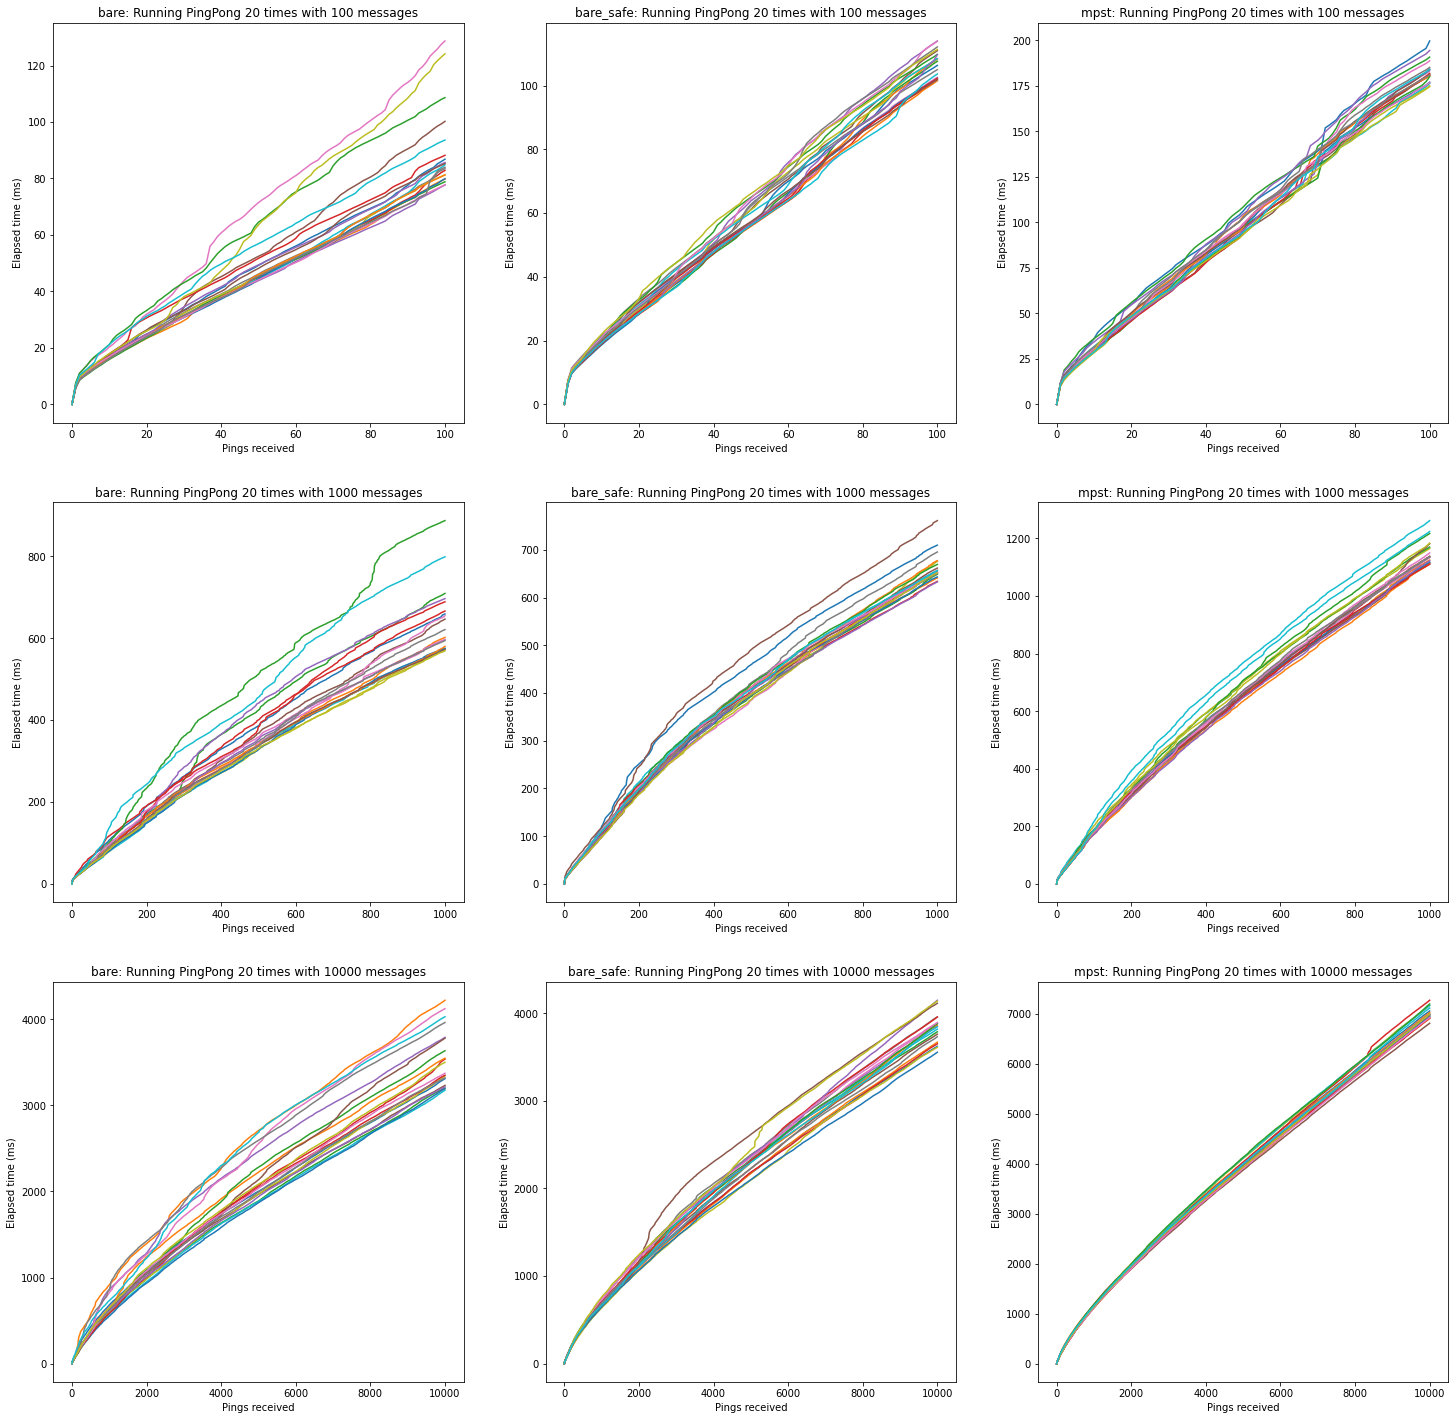

In [8]:
fig = plt.figure(figsize=(25, 25))
for i, message_count in enumerate(num_messages):
    for j, category in enumerate(categories):
        idx = i * 3 + j + 1
        ax = fig.add_subplot(3, 3, idx)
        visualise_execution(fig, ax, message_count, category)

## Comparing total elapsed time

In [9]:
print('Total Elapsed Time')
display(data.df_total_elapsed())

print('\n\n')

print('Average Elapsed Time per Ping-Pong')
display(data.df_average_elapsed())

Total Elapsed Time


,bare,bare_safe,mpst
100,89.64,107.09,186.23
1000,642.92,663.91,1155.48
10000,3542.16,3837.97,7015.25





Average Elapsed Time per Ping-Pong


,bare,bare_safe,mpst
100,0.90,1.07,1.86
1000,0.64,0.66,1.16
10000,0.35,0.38,0.70


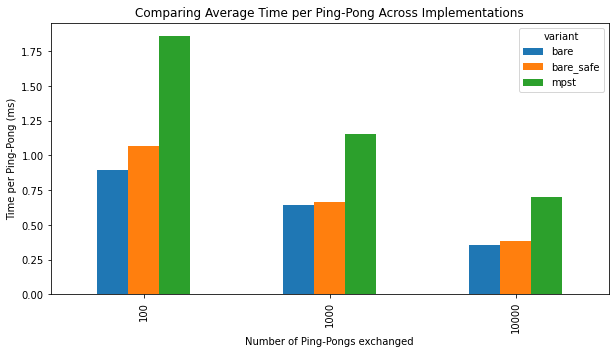

In [10]:
data.plt_average_elapsed().plot(kind='bar', figsize=(10, 5))
plt.xlabel('Number of Ping-Pongs exchanged')
plt.ylabel('Time per Ping-Pong (ms)')
plt.title('Comparing Average Time per Ping-Pong Across Implementations')

extent = plt.gca().get_window_extent().transformed(fig.dpi_scale_trans.inverted())
plt.savefig('time_per_msg.png',
            bbox_inches=extent.expanded(1.25, 1.5))
plt.show()